# Monitor Training and Numerical Evaluation

This script visualizes learning curves thorughout training, evaluates the trained models, and displays GradCAM results.

In [9]:
%load_ext autoreload
%autoreload 2

import os
import json
import glob
import shutil
import torch
import random 
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import patches
from sklearn.metrics import confusion_matrix

from detectron2.engine import DefaultPredictor
from detectron2.data import MetadataCatalog, DatasetCatalog
from detectron2.utils.visualizer import Visualizer, ColorMode
from detectron2 import model_zoo

from utils.evaluation import plot_precision_recall, plot_precision_recall_single, get_precisions_recalls
from utils.hyperparameter import setup_default
from utils.dataloader import register_dataset, register_datasets
from utils.confmat import confusion_matrix_report, plot_confusion_matrix
from utils.gradcam import Detectron2GradCAM


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## 1) Learning curves:

faster_rcnn_R_50_FPN_1x-20221208-055627
#75 final results:
{'bbox/AP': 38.698740482452, 'bbox/AP-BCNHA': 47.9275963129369, 'bbox/AP-BLSKA': 60.58814954265429, 'bbox/AP-BRPEA': 56.435503861846605, 'bbox/AP-BRPEC': 40.536565378380686, 'bbox/AP-BRPEW': 36.5021430486226, 'bbox/AP-CAEGA': 57.845364770486896, 'bbox/AP-GBHEA': 34.16185621783163, 'bbox/AP-GBHEC': 11.759149034871317, 'bbox/AP-GREGA': 38.390102599015094, 'bbox/AP-GREGC': 14.711028245681712, 'bbox/AP-LAGUA': 52.29517400178465, 'bbox/AP-LAGUF': 27.899798344060144, 'bbox/AP-MEGRT': 23.462548065783057, 'bbox/AP-REEGA': 51.56398992713294, 'bbox/AP-REEGWMA': 47.960530822618416, 'bbox/AP-ROSPA': 39.77527058487825, 'bbox/AP-ROT': 63.57435496783982, 'bbox/AP-SAT': 51.36907873925588, 'bbox/AP-SNEGA': 5.621952928883622, 'bbox/AP-TRHEA': 44.022066429225085, 'bbox/AP-Unknown Bird': 0.0, 'bbox/AP-WHIBA': 44.970066790154476, 'bbox/AP50': 65.96758356575265, 'bbox/AP75': 42.10527798972875, 'bbox/APl': 34.920429317221654, 'bbox/APm': 34.607137432

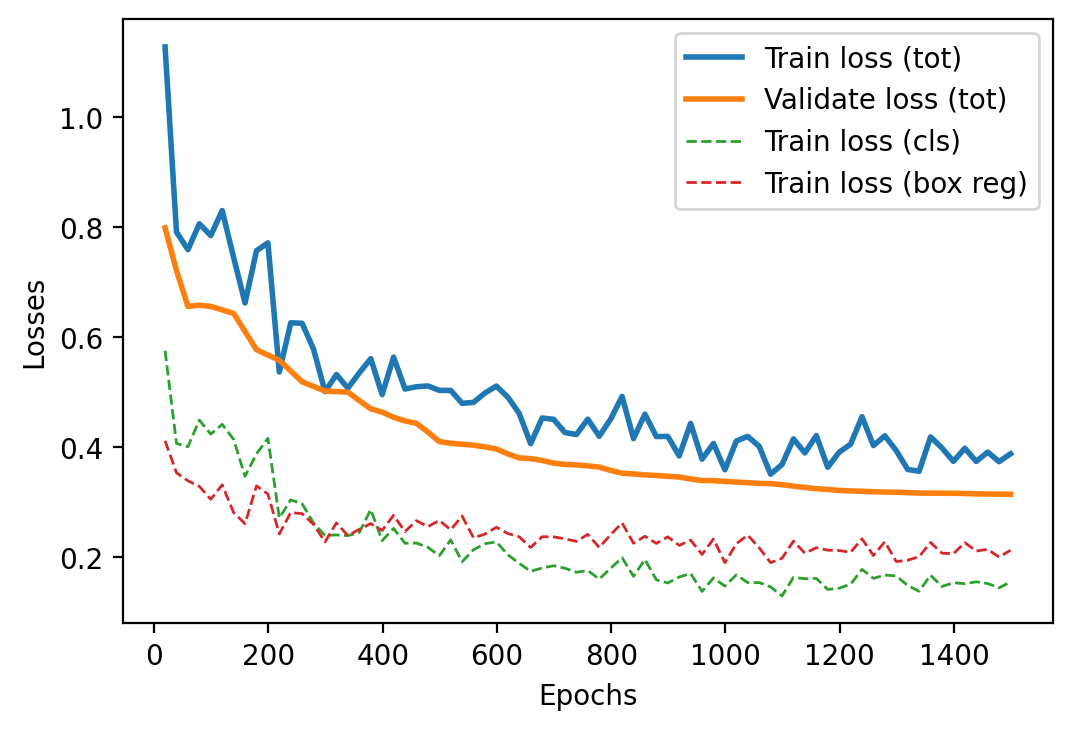

In [3]:
# trained model dir
out_dir = '../Audubon_F21_github/output/Training_models/faster_rcnn_21class_set_I_aug_wloss/'
#mod_name = 'faster_rcnn_R_50_FPN_1x-20221204-190712'

# find the best performing model
dfc_dict = {}
for mdir in glob.glob(out_dir + 'faster_rcnn_R_50_FPN_1x-*'):
    df_parse = None
    if not os.path.exists(mdir + '/metrics.json'):
        continue
    with open (mdir + '/metrics.json') as f:
        lines = f.read().split('\n')
        for i,l in enumerate(lines):
            if l:
                d = json.loads(l)
                if df_parse is None: 
                    df_parse = pd.DataFrame(columns = list(d.keys()))
                try:
                    df_parse.loc[len(df_parse.index)] = list(d.values())
                except:
                    pass
    if 'validation_loss' in df_parse:
        dfc_dict[os.path.basename(mdir)] = min(df_parse['validation_loss'])
mod_name = min(dfc_dict, key=dfc_dict.get)
print(mod_name)

mod_dir = os.path.join(out_dir, mod_name)
df_parse = None
with open (mod_dir + '/metrics.json') as f:
    lines = f.read().split('\n')
    for i,l in enumerate(lines):
        if l:
            d = json.loads(l)
            if df_parse is None: 
                df_parse = pd.DataFrame(columns = list(d.keys()))
            try:
                df_parse.loc[len(df_parse.index)] = list(d.values())
            except:
                print(f'#{i} final results:')
                print(d)
print(list(df_parse))
df_curves = df_parse[['iteration','total_loss','loss_cls','loss_box_reg','validation_loss']]

plt.figure(figsize=(6,4), dpi=200)
iters = df_curves.iteration.values.astype(int)
plt.plot(iters, df_curves.total_loss.values.astype(float), label = 'Train loss (tot)', lw=2)
plt.plot(iters, df_curves.validation_loss.values.astype(float), label = 'Validate loss (tot)', lw=2)
plt.plot(iters, df_curves.loss_cls.values.astype(float), label = 'Train loss (cls)', ls='--', lw=1)
plt.plot(iters, df_curves.loss_box_reg.values.astype(float), label = 'Train loss (box reg)', ls='--', lw=1)

plt.xlabel('Epochs')
plt.ylabel('Losses')
# plt.ylim(0.1, 1.8)

plt.legend()
plt.show()

## 2) Numerical evaluations on test set:

[12/08 07:26:04 d2.checkpoint.c2_model_loading]: Following weights matched with model:
| Names in Model                                  | Names in Checkpoint                                                                                  | Shapes                                          |
|:------------------------------------------------|:-----------------------------------------------------------------------------------------------------|:------------------------------------------------|
| backbone.bottom_up.res2.0.conv1.*               | backbone.bottom_up.res2.0.conv1.{norm.bias,norm.running_mean,norm.running_var,norm.weight,weight}    | (64,) (64,) (64,) (64,) (64,64,1,1)             |
| backbone.bottom_up.res2.0.conv2.*               | backbone.bottom_up.res2.0.conv2.{norm.bias,norm.running_mean,norm.running_var,norm.weight,weight}    | (64,) (64,) (64,) (64,) (64,64,3,3)             |
| backbone.bottom_up.res2.0.conv3.*               | backbone.bottom_up.res2.0.conv3.{norm.bia

Test inference:
[12/08 07:26:04 d2.evaluation.coco_evaluation]: Trying to convert 'birds_species_Test' to COCO format ...
[12/08 07:26:04 d2.data.datasets.coco]: Converting annotations of dataset 'birds_species_Test' to COCO format ...)
[12/08 07:26:15 d2.data.datasets.coco]: Converting dataset dicts into COCO format
[12/08 07:26:15 d2.data.datasets.coco]: Conversion finished, #images: 1250, #annotations: 4979
[12/08 07:26:15 d2.data.datasets.coco]: Caching COCO format annotations at './output/Training_models/faster_rcnn_21class_set_I_aug_wloss/faster_rcnn_R_50_FPN_1x-20221208-055627/birds_species_Test_coco_format.json' ...
[12/08 07:26:24 d2.data.build]: Distribution of instances among all 22 categories:
|   category   | #instances   |  category  | #instances   |  category  | #instances   |
|:------------:|:-------------|:----------:|:-------------|:----------:|:-------------|
|    BCNHA     | 88           |   BLSKA    | 92           |   BRPEA    | 262          |
|    BRPEC     | 60  

/opt/conda/lib/python3.7/site-packages/torch/functional.py:445: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at  /opt/conda/conda-bld/pytorch_1634272168290/work/aten/src/ATen/native/TensorShape.cpp:2157.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


[12/08 07:26:25 d2.evaluation.evaluator]: Inference done 11/1250. Dataloading: 0.0159 s/iter. Inference: 0.0341 s/iter. Eval: 0.0001 s/iter. Total: 0.0501 s/iter. ETA=0:01:02
[12/08 07:26:30 d2.evaluation.evaluator]: Inference done 107/1250. Dataloading: 0.0179 s/iter. Inference: 0.0341 s/iter. Eval: 0.0001 s/iter. Total: 0.0522 s/iter. ETA=0:00:59
[12/08 07:26:35 d2.evaluation.evaluator]: Inference done 204/1250. Dataloading: 0.0177 s/iter. Inference: 0.0341 s/iter. Eval: 0.0001 s/iter. Total: 0.0520 s/iter. ETA=0:00:54
[12/08 07:26:40 d2.evaluation.evaluator]: Inference done 299/1250. Dataloading: 0.0179 s/iter. Inference: 0.0341 s/iter. Eval: 0.0001 s/iter. Total: 0.0523 s/iter. ETA=0:00:49
[12/08 07:26:45 d2.evaluation.evaluator]: Inference done 394/1250. Dataloading: 0.0180 s/iter. Inference: 0.0342 s/iter. Eval: 0.0001 s/iter. Total: 0.0524 s/iter. ETA=0:00:44
[12/08 07:26:50 d2.evaluation.evaluator]: Inference done 489/1250. Dataloading: 0.0181 s/iter. Inference: 0.0342 s/iter. 

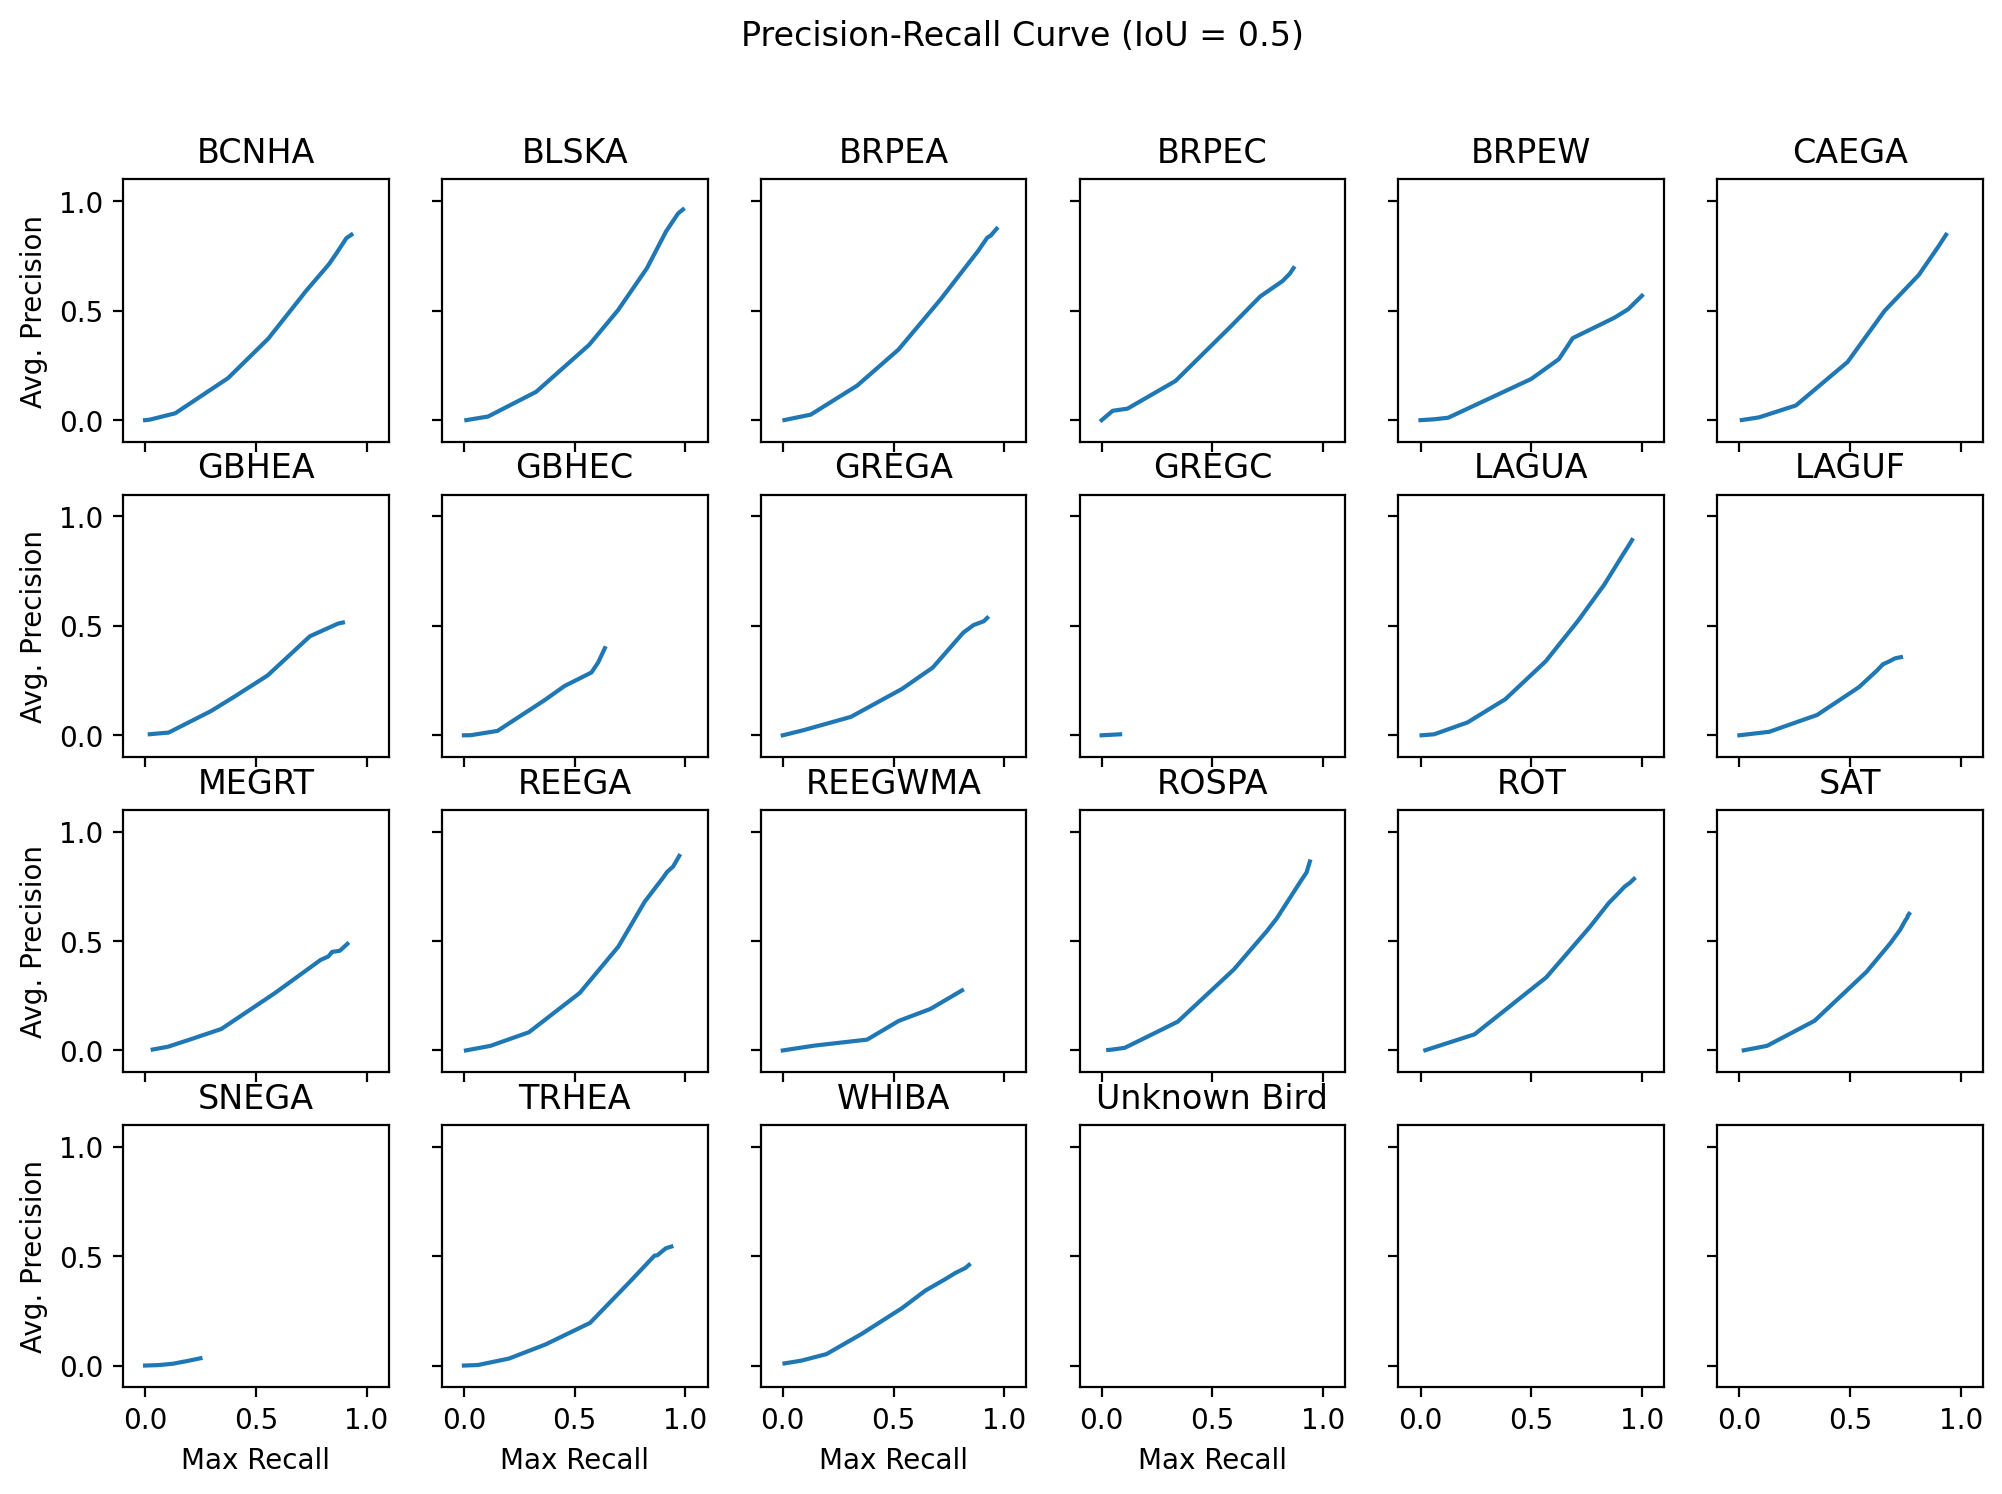

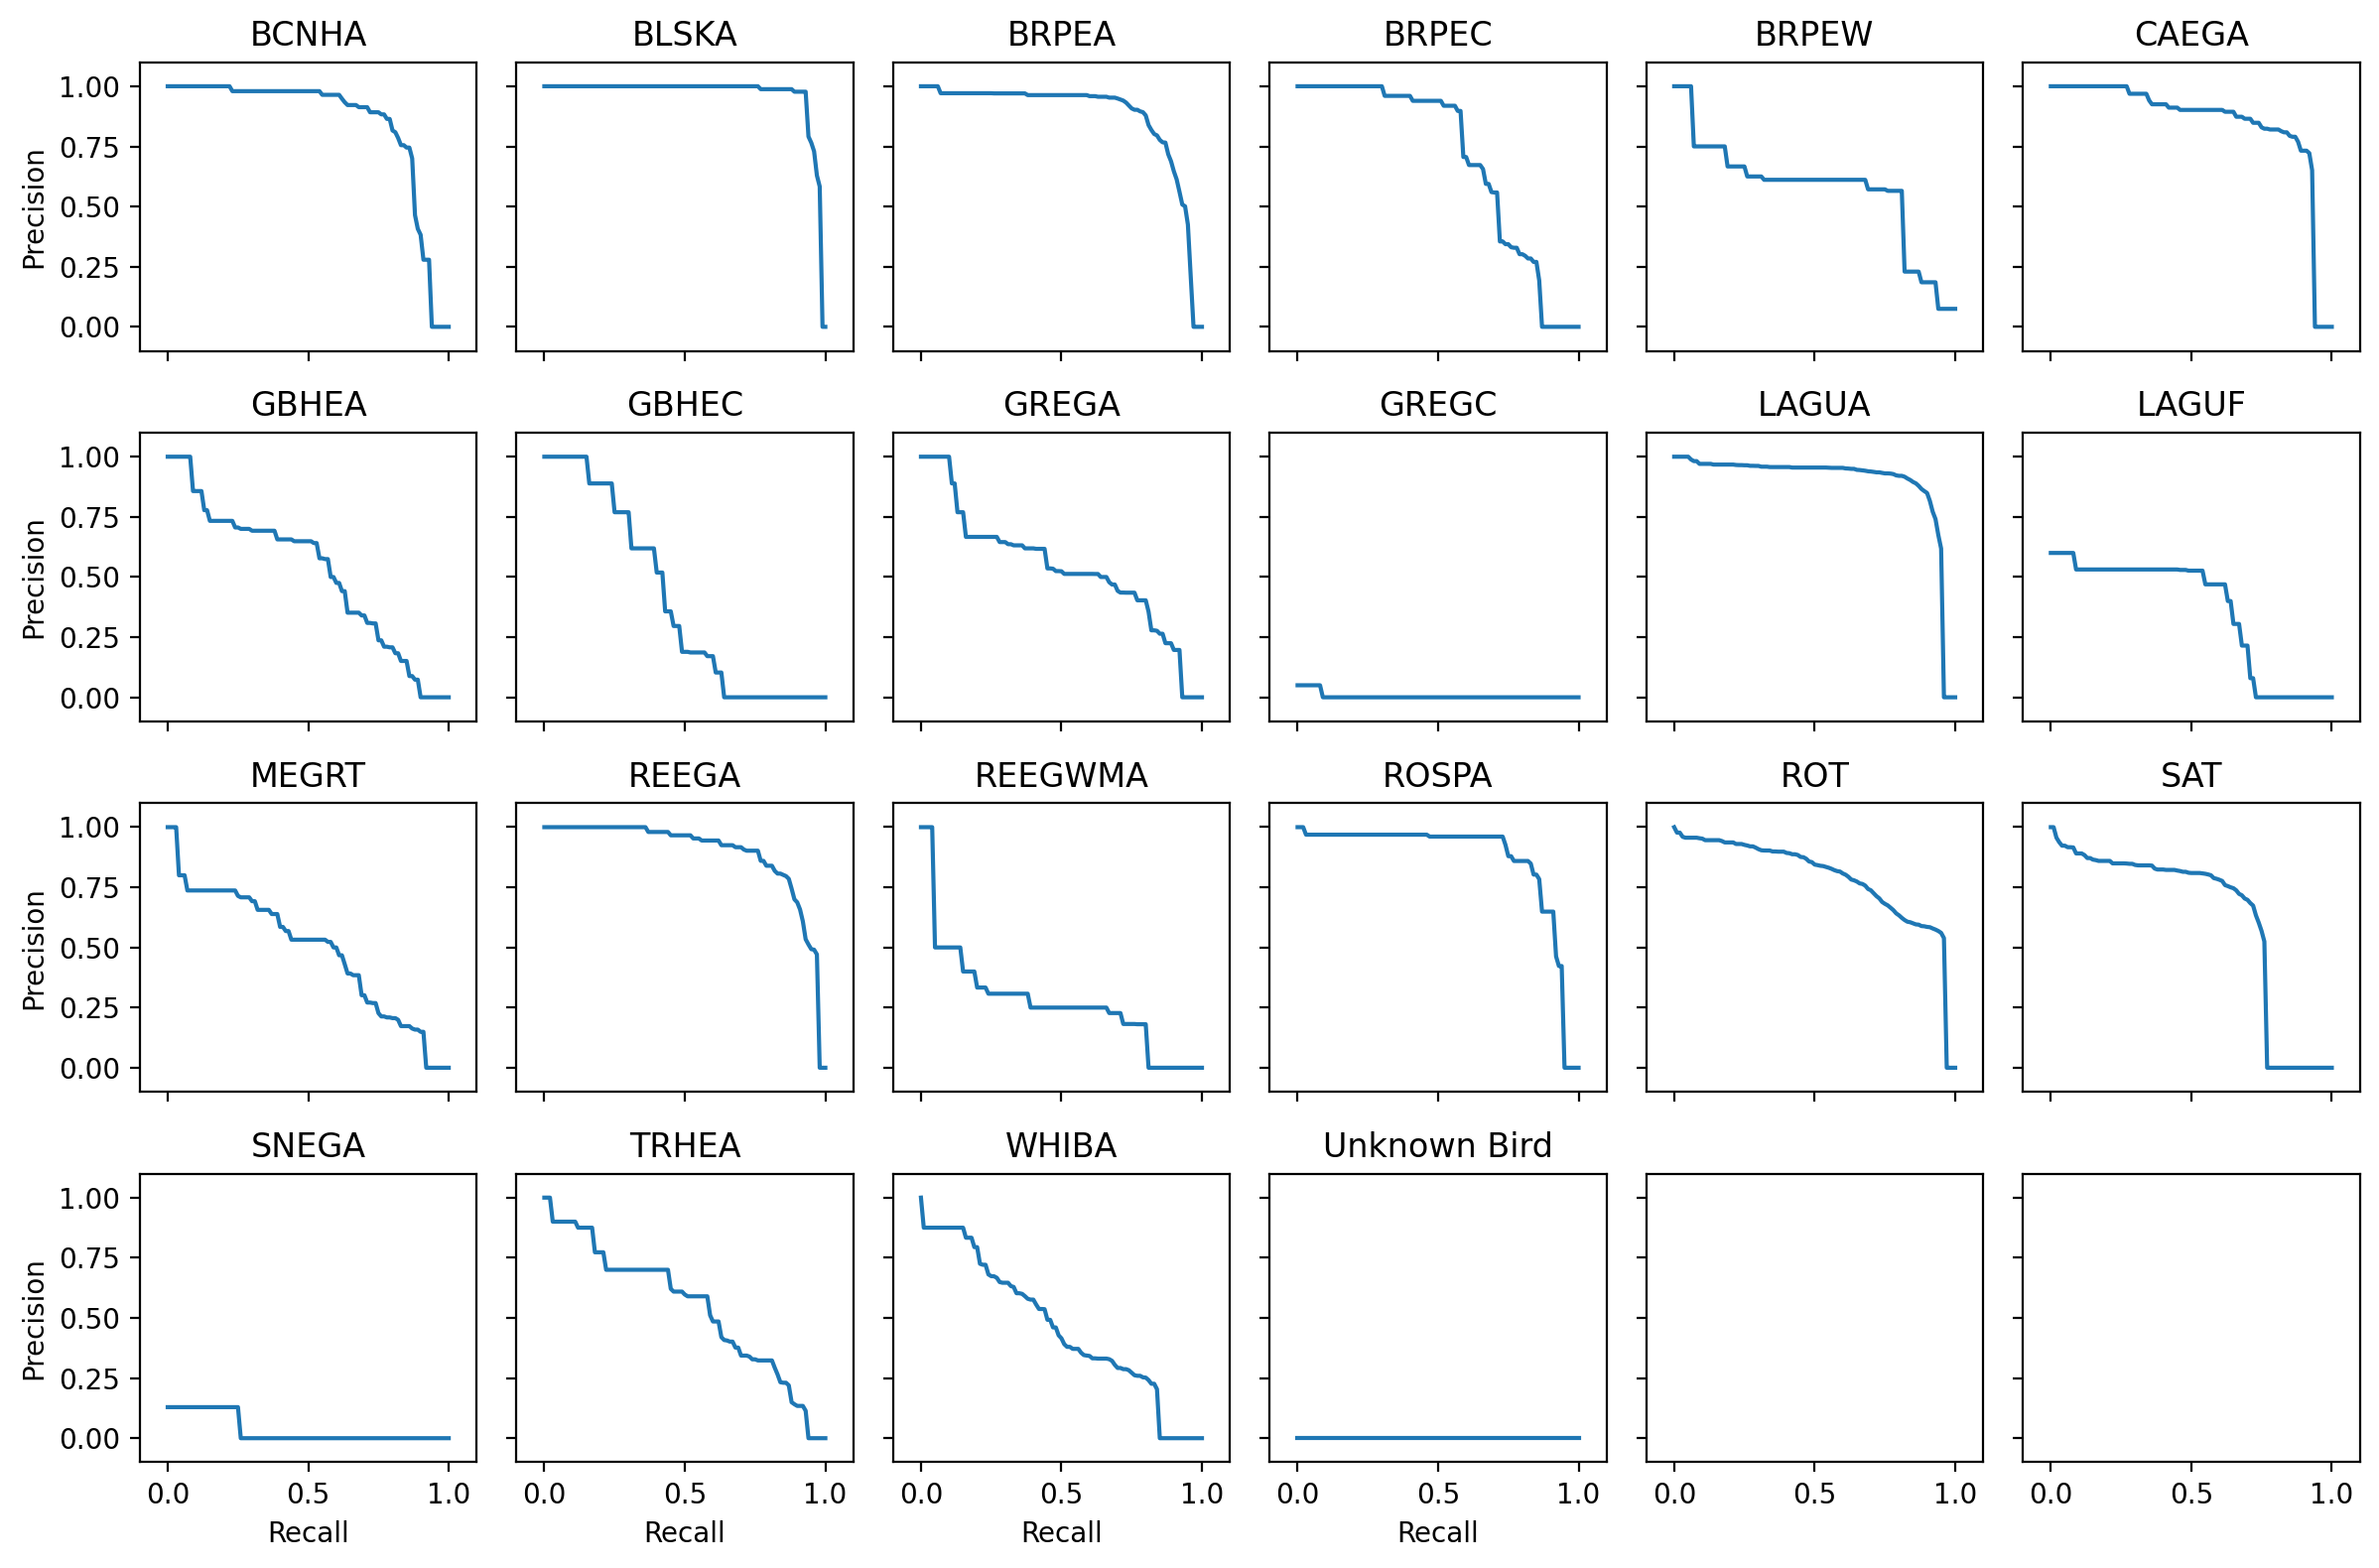

In [4]:
# Retrieve training parameters
with open(os.path.join(mod_dir, 'parameters.txt')) as f:
    cfg_parms = json.loads(f.read())
cfg_parms['mod_dirname'] = mod_name
cfg = setup_default(cfg_parms)

# Path to the model we just trained
model_file = os.path.join(mod_dir, "model_final.pth")
cfg.MODEL.WEIGHTS = model_file
predictor = DefaultPredictor(cfg)

# Register datasets for detectron2
data_dir = "./data/22All/split/"
img_ext = '.JPEG'
dirs_full = [os.path.join(data_dir, d) for d in os.listdir(data_dir) if not d.startswith('.') and not d.startswith('_')]

for d in dirs_full:
    register_dataset(
        d, img_ext, cfg_parms['BIRD_SPECIES'], unknown_bird_category = True,
        bird_species_colors = [(0,0,0)]*len(cfg_parms['BIRD_SPECIES'])
    )

print('Test inference:')
all_class = cfg_parms['BIRD_SPECIES'] + ["Unknown Bird"]
test_precisions, test_max_recalls = get_precisions_recalls(cfg, predictor, "birds_species_Test")
perf = plot_precision_recall(
    test_precisions, test_max_recalls, all_class,
    [(0,0,0)]*(len(cfg_parms['BIRD_SPECIES'])+1)
)

Top-10 best performing classes:


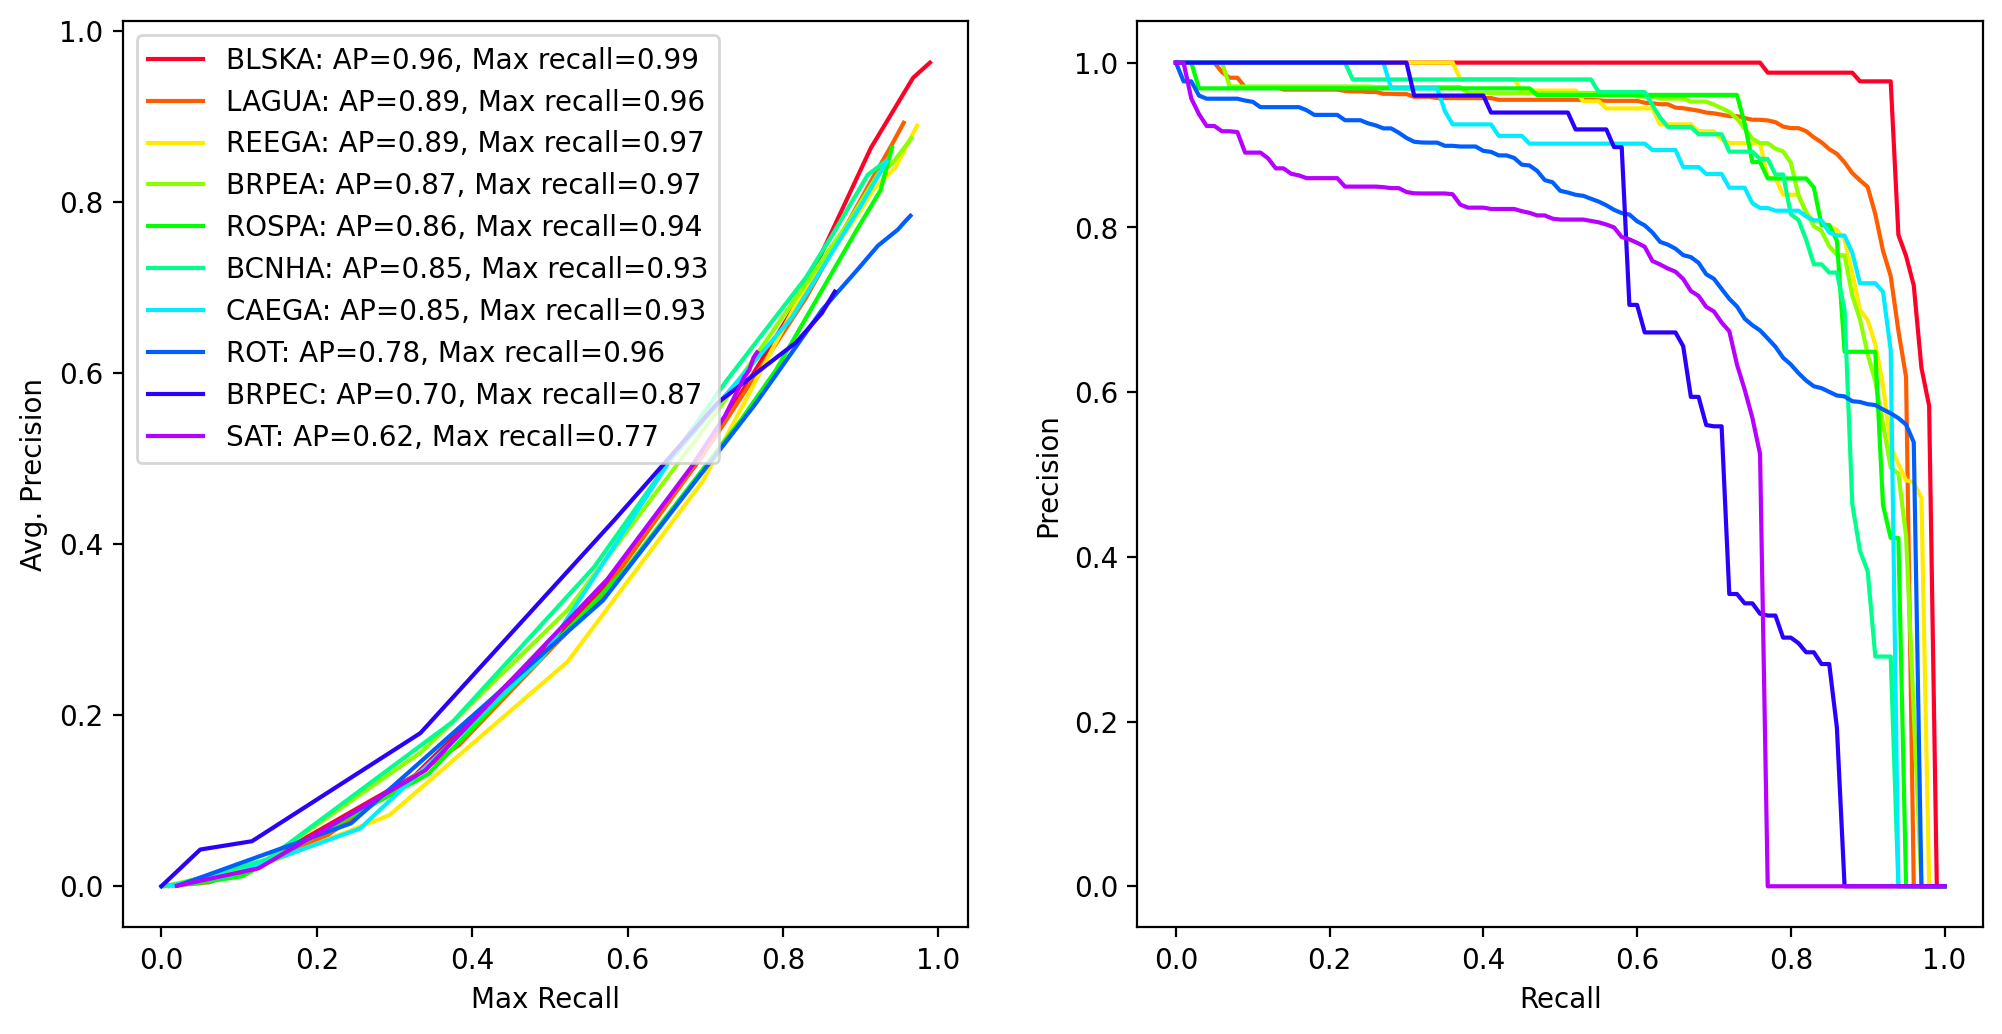

In [5]:
disp_class = sorted(perf['AP'], key=perf['AP'].get, reverse=True)[:10]
disp_cidx = [all_class.index(c) for c in disp_class]
color_map = plt.get_cmap('gist_rainbow')
ncolors = len(disp_class)

print("Top-10 best performing classes:")
plot_precision_recall_single(
    test_precisions[:,:,disp_cidx,:,:], test_max_recalls[:,disp_cidx,:,:], disp_class,
    [color_map(1.*i/ncolors) for i in range(ncolors)]
)

## 3) Confusion matrix on test set:

In [27]:
out_res = os.path.join(out_dir, 'predicted_results')
shutil.rmtree(out_res, ignore_errors=True)
os.mkdir(out_res)

# Confusion matrix
pred_total, truth_total = confusion_matrix_report(
    DatasetCatalog.get("birds_species_Test"), 
    predictor, 
    all_class, 
    img_ext  ='JPEG', 
    iou_thre = 0.5, 
    save_to  = None #out_res
)


  0%|          | 0/1250 [00:00<?, ?it/s]

1 [{'bbox': [462, 622, 48, 18], 'bbox_mode': <BoxMode.XYWH_ABS: 1>, 'category_id': 10}]
0 []
2 [{'bbox': [39, 194, 99, 78], 'bbox_mode': <BoxMode.XYWH_ABS: 1>, 'category_id': 10}, {'bbox': [0, 409, 77, 52], 'bbox_mode': <BoxMode.XYWH_ABS: 1>, 'category_id': 10}]
1 [{'bbox': [0, 510, 89, 51], 'bbox_mode': <BoxMode.XYWH_ABS: 1>, 'category_id': 10}]
1 [{'bbox': [6, 574, 90, 66], 'bbox_mode': <BoxMode.XYWH_ABS: 1>, 'category_id': 10}]
1 [{'bbox': [201, 22, 86, 72], 'bbox_mode': <BoxMode.XYWH_ABS: 1>, 'category_id': 10}]
2 [{'bbox': [577, 0, 38, 69], 'bbox_mode': <BoxMode.XYWH_ABS: 1>, 'category_id': 10}, {'bbox': [162, 443, 45, 96], 'bbox_mode': <BoxMode.XYWH_ABS: 1>, 'category_id': 10}]
0 []
0 []


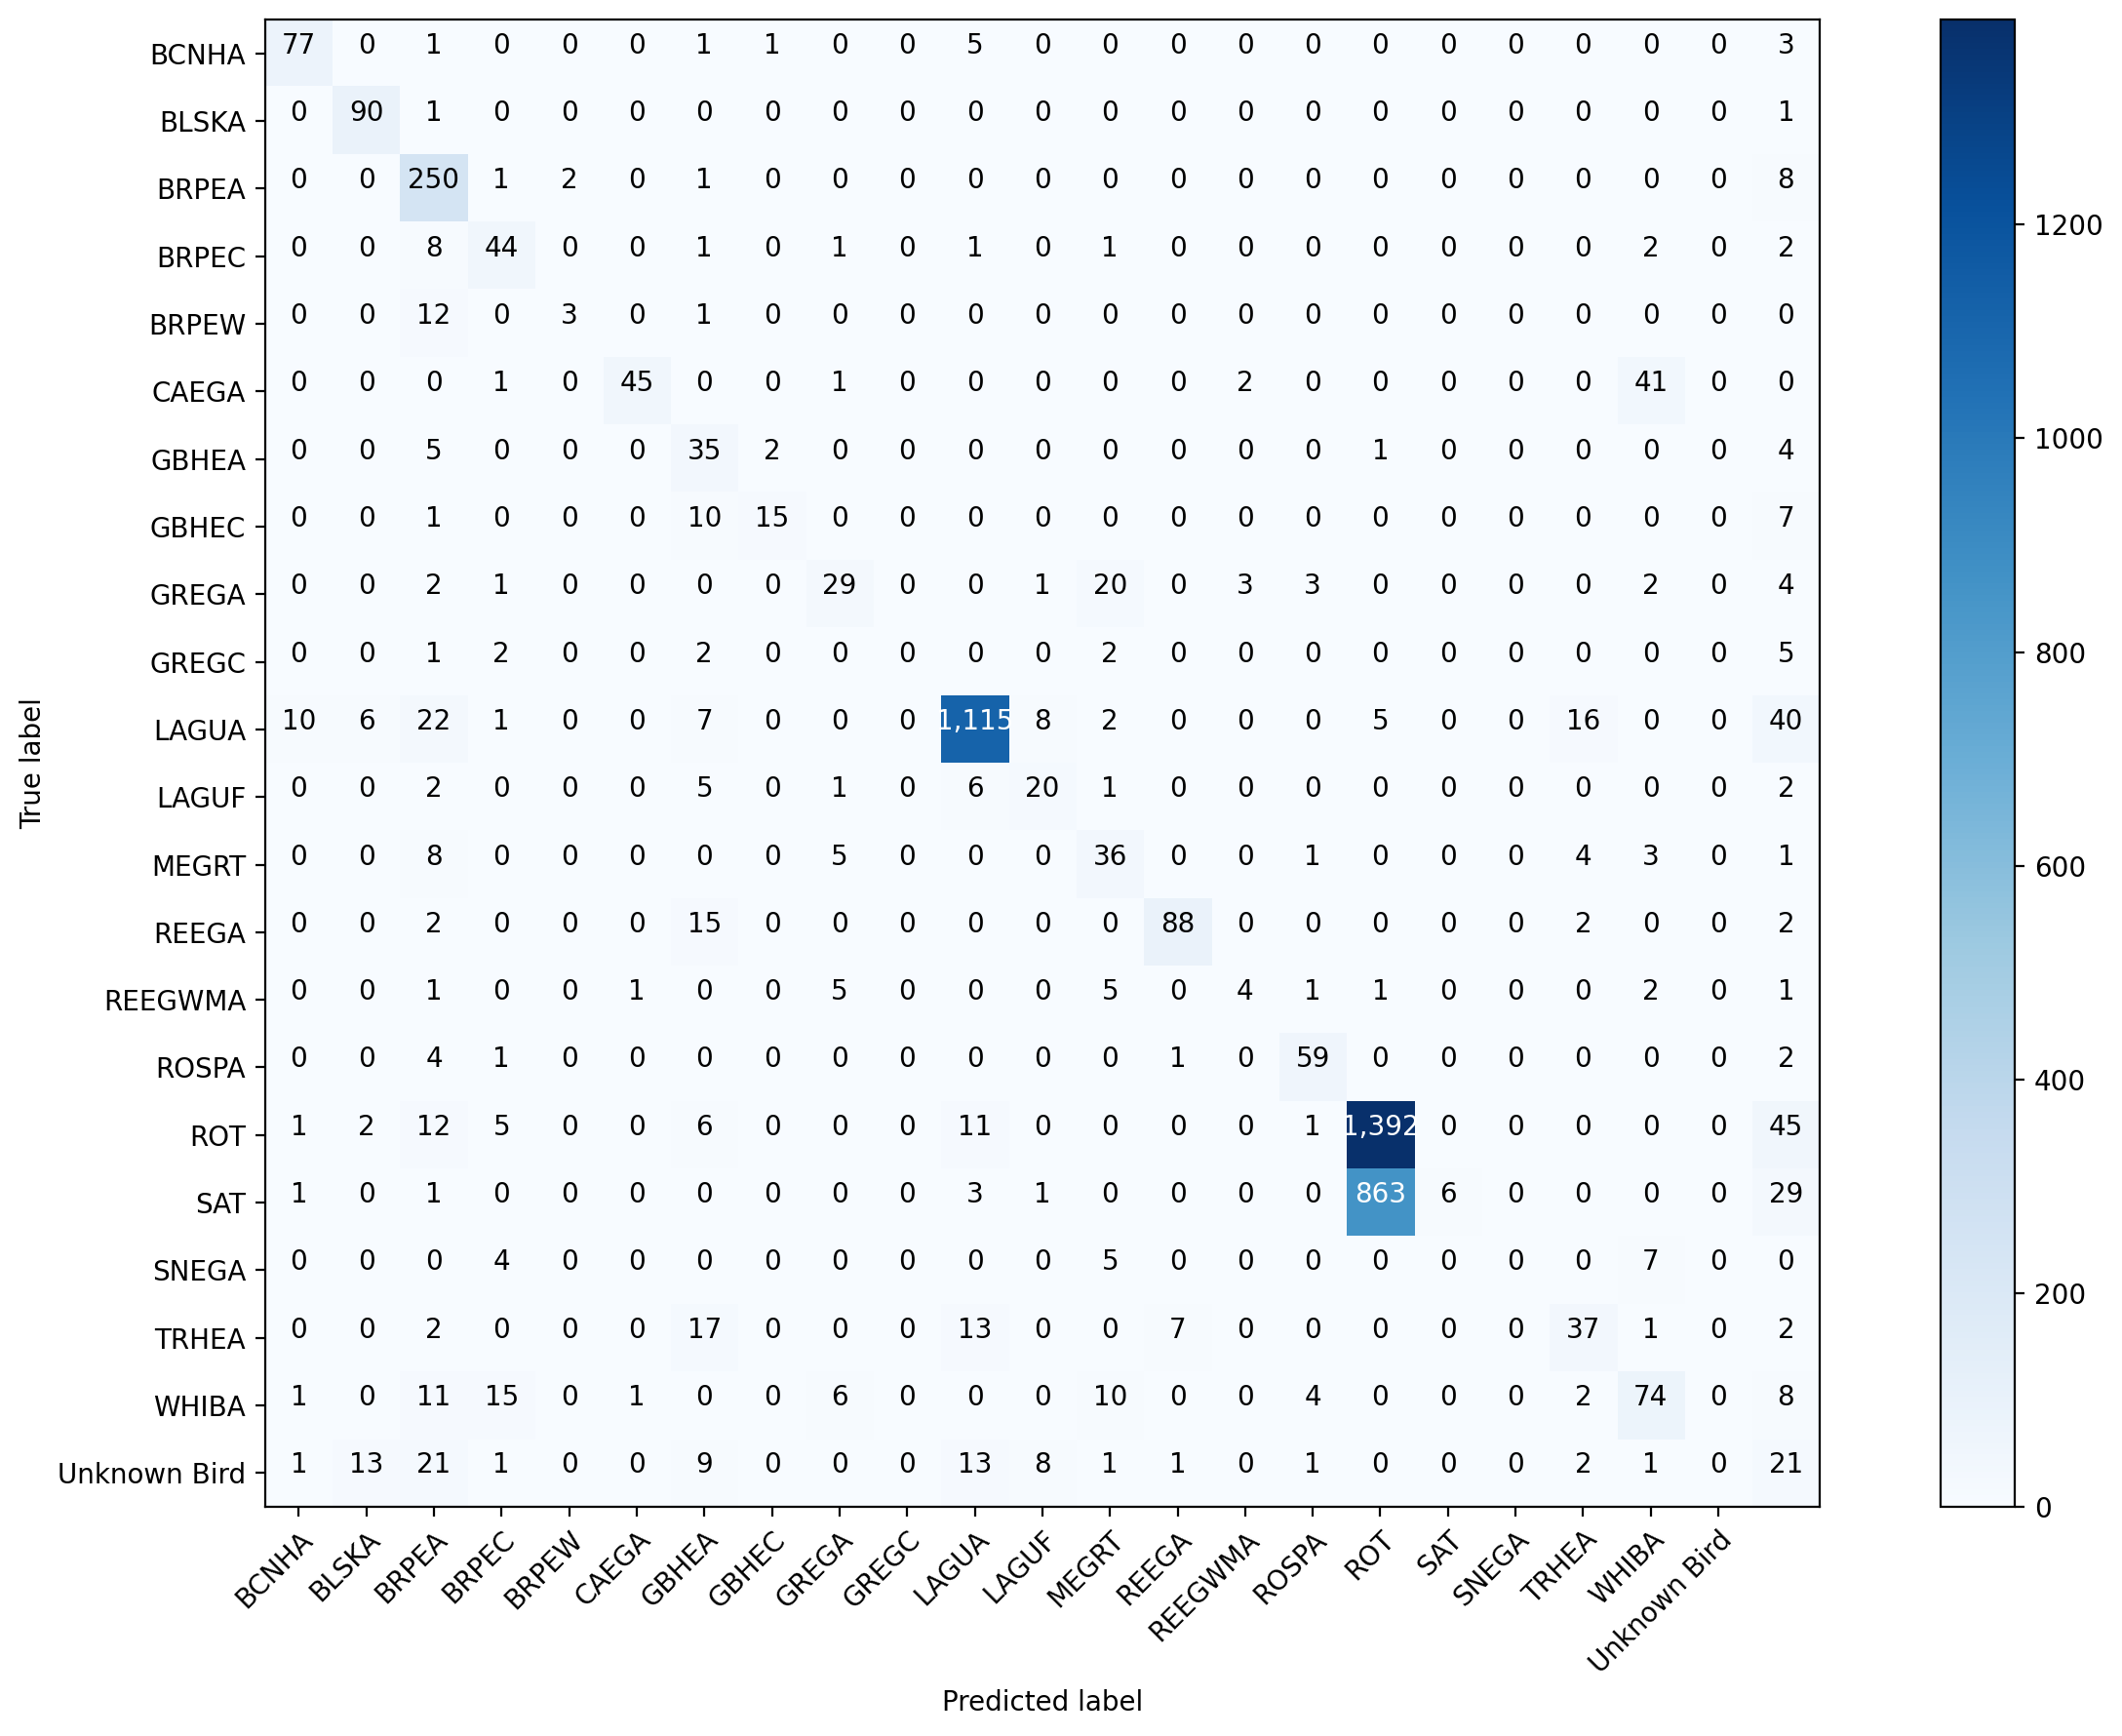

In [7]:

cm = confusion_matrix(truth_total, pred_total)
fig, ax = plt.subplots(1,1, figsize = (13,9), dpi = 200)
plot_confusion_matrix(cm[:-1,:], all_class, figure = (fig, ax), normalize = False)


## 4) Visualize detection result examples:


 Test examples: ./data/22All/split/Test/DJI_20220521113131_0273_6_6.JPEG


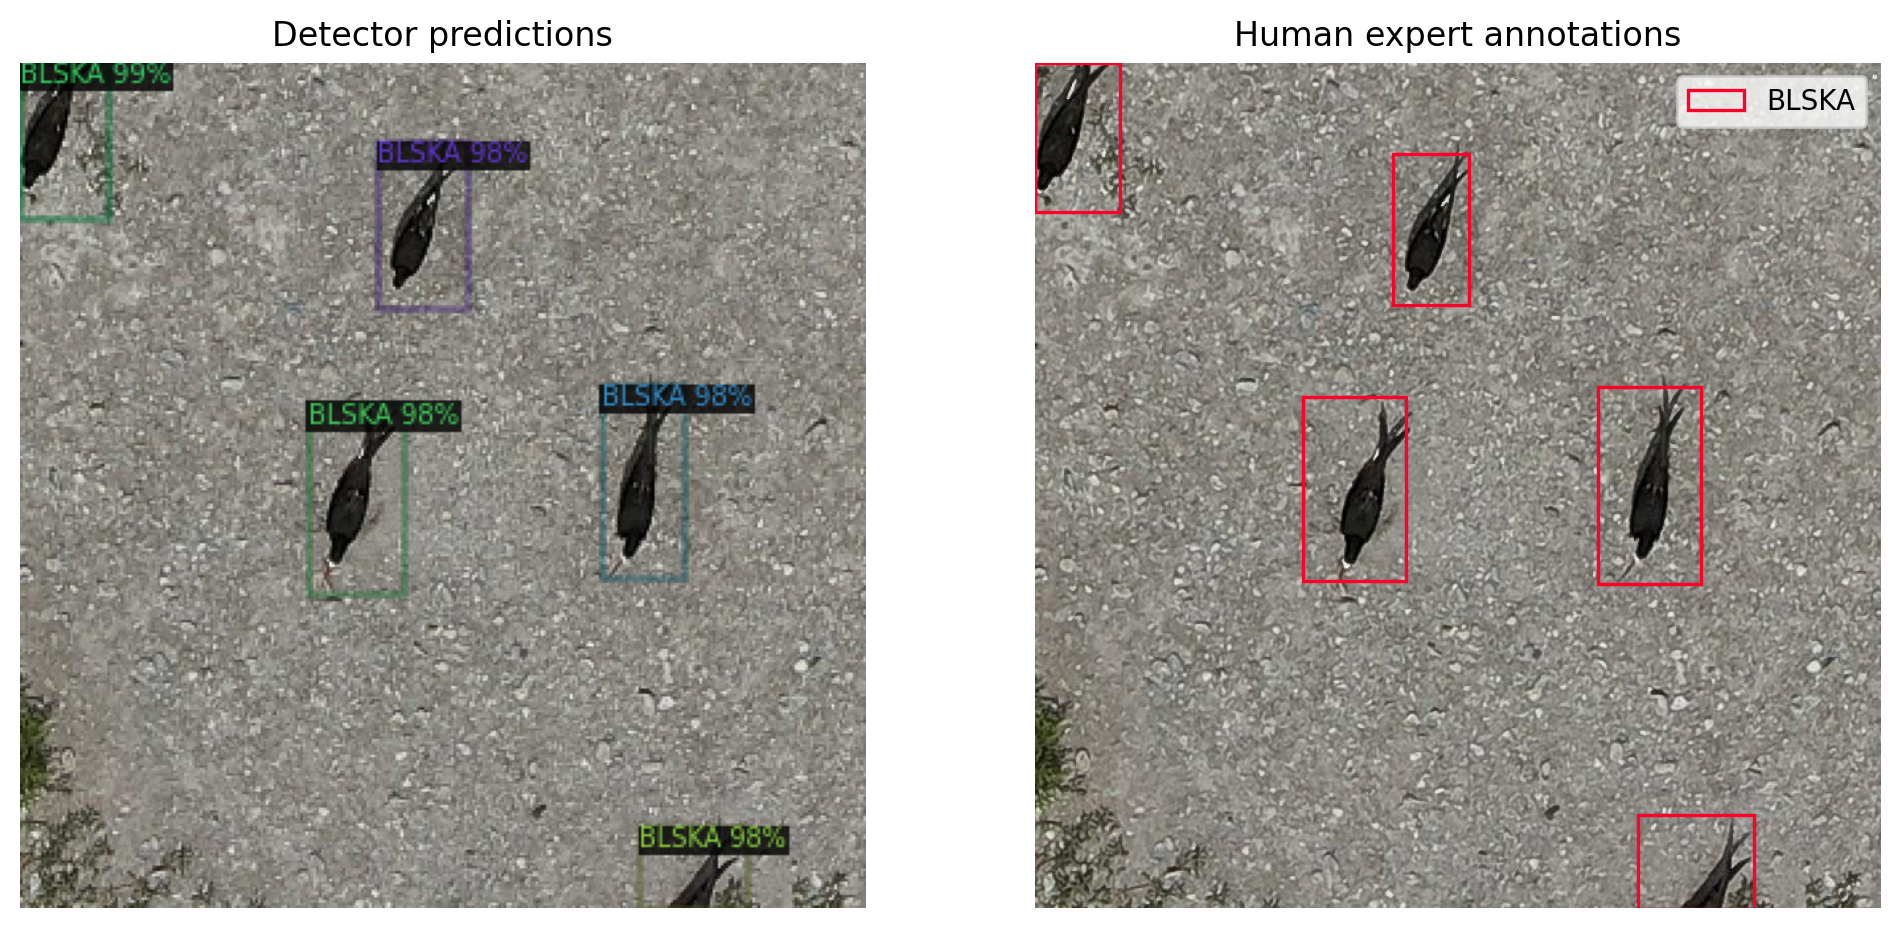

In [26]:

lab_cat2cls = dict(zip(range(len(all_class)), all_class))

# Plot examples of detections on validation and testing tiled images 
for d in ["Test"]:
    dataset_dicts = DatasetCatalog.get(f"birds_species_{d}")
    p = np.array([len(dd['annotations']) for dd in dataset_dicts])
    
    # randomly sample an example, prefer more birds
    k = np.random.choice(dataset_dicts, p = p/p.sum())
    print(f'\n {d} examples:', k['file_name'])
        
    im = cv2.imread(k["file_name"])
    im = cv2.cvtColor(im, cv2.COLOR_RGB2BGR)

    height, width = im.shape[:2]
    x_im = torch.as_tensor(im.astype("float32").transpose(2, 0, 1))
    inputs = [{"image": x_im, "height": height, "width": width}]        

    outputs0 = predictor.model(inputs)[0]
    outputs = outputs0["instances"].to("cpu")
    outputs = outputs[outputs.scores > 0.5]
    v = Visualizer(
        im, metadata = MetadataCatalog.get(f"birds_species_{d}"), 
        scale = .5, instance_mode = ColorMode.SEGMENTATION
    )
    out = v.draw_instance_predictions(outputs)

    fig, axes = plt.subplots(1, 2, figsize=(12,6), dpi=200)
    [ax.axis('off') for ax in axes]
    
    axes[0].imshow(out.get_image())
    axes[0].set(title='Detector predictions')
    axes[0].axis('off')
    
    # ground truth annotations
    axes[1].imshow(im)
    axes[1].set(title='Human expert annotations')
    pres_class = list(set(lab_cat2cls[ki['category_id']] for ki in k['annotations']))
    pres_colors = [color_map(1.*i/len(pres_class)) for i in range(len(pres_class))]
    for ki in k['annotations']:
        lab_true = lab_cat2cls[ki['category_id']]
        rect = patches.Rectangle(
            ki['bbox'][:2], *ki['bbox'][2:], linewidth = 1.2, ls = '-', 
            edgecolor = pres_colors[pres_class.index(lab_true)], 
            facecolor = 'none', label = lab_true
        )
        axes[1].add_patch(rect)
        
    # remove duplicated legend
    axes[1].legend(*[*zip(*{l:h for h,l in zip(*axes[1].get_legend_handles_labels())}.items())][::-1])


## 5) GradCAM interpretability visualization: 

In [ ]:
colors = {'ROT':'r', 'SAT':'cyan', 'LAGUA':'w'}

# example image to show
img_file = './data/example/20220521 - Chester Island 10k-05-11_12_5.JPEG'
config_file = model_zoo.get_config_file(f"COCO-Detection/{cfg_parms['model_name']}.yaml")

# specify which layer to visualize
layer_name = "backbone.bottom_up.res5.2.conv3"

cam_extractor = Detectron2GradCAM(
    config_file = config_file, 
    model_file  = model_file, 
    cfg_parms   = cfg_parms
)

im_grad = {k:{} for k in cfg_parms['BIRD_SPECIES']}
instance = 0 #CAM is generated per object instance, not per class!
while True:
    try: 
        # do for all detected instances
        image_dict, cam_orig = cam_extractor.get_cam(
            img_file        = img_file, 
            target_instance = instance, 
            layer_name      = layer_name, 
            grad_cam_type   = "GradCAM++"
        )
    except:
        break
    im_grad[cfg_parms['BIRD_SPECIES'][image_dict["label"]]][instance] = image_dict["cam"]
    instance += 1
    print(f"instance#{instance}")
    
# aggregate grads of all instances in the same class for visualization
im_cam = {k:np.array(list(grad.values())).mean(0) for k,grad in im_grad.items()}

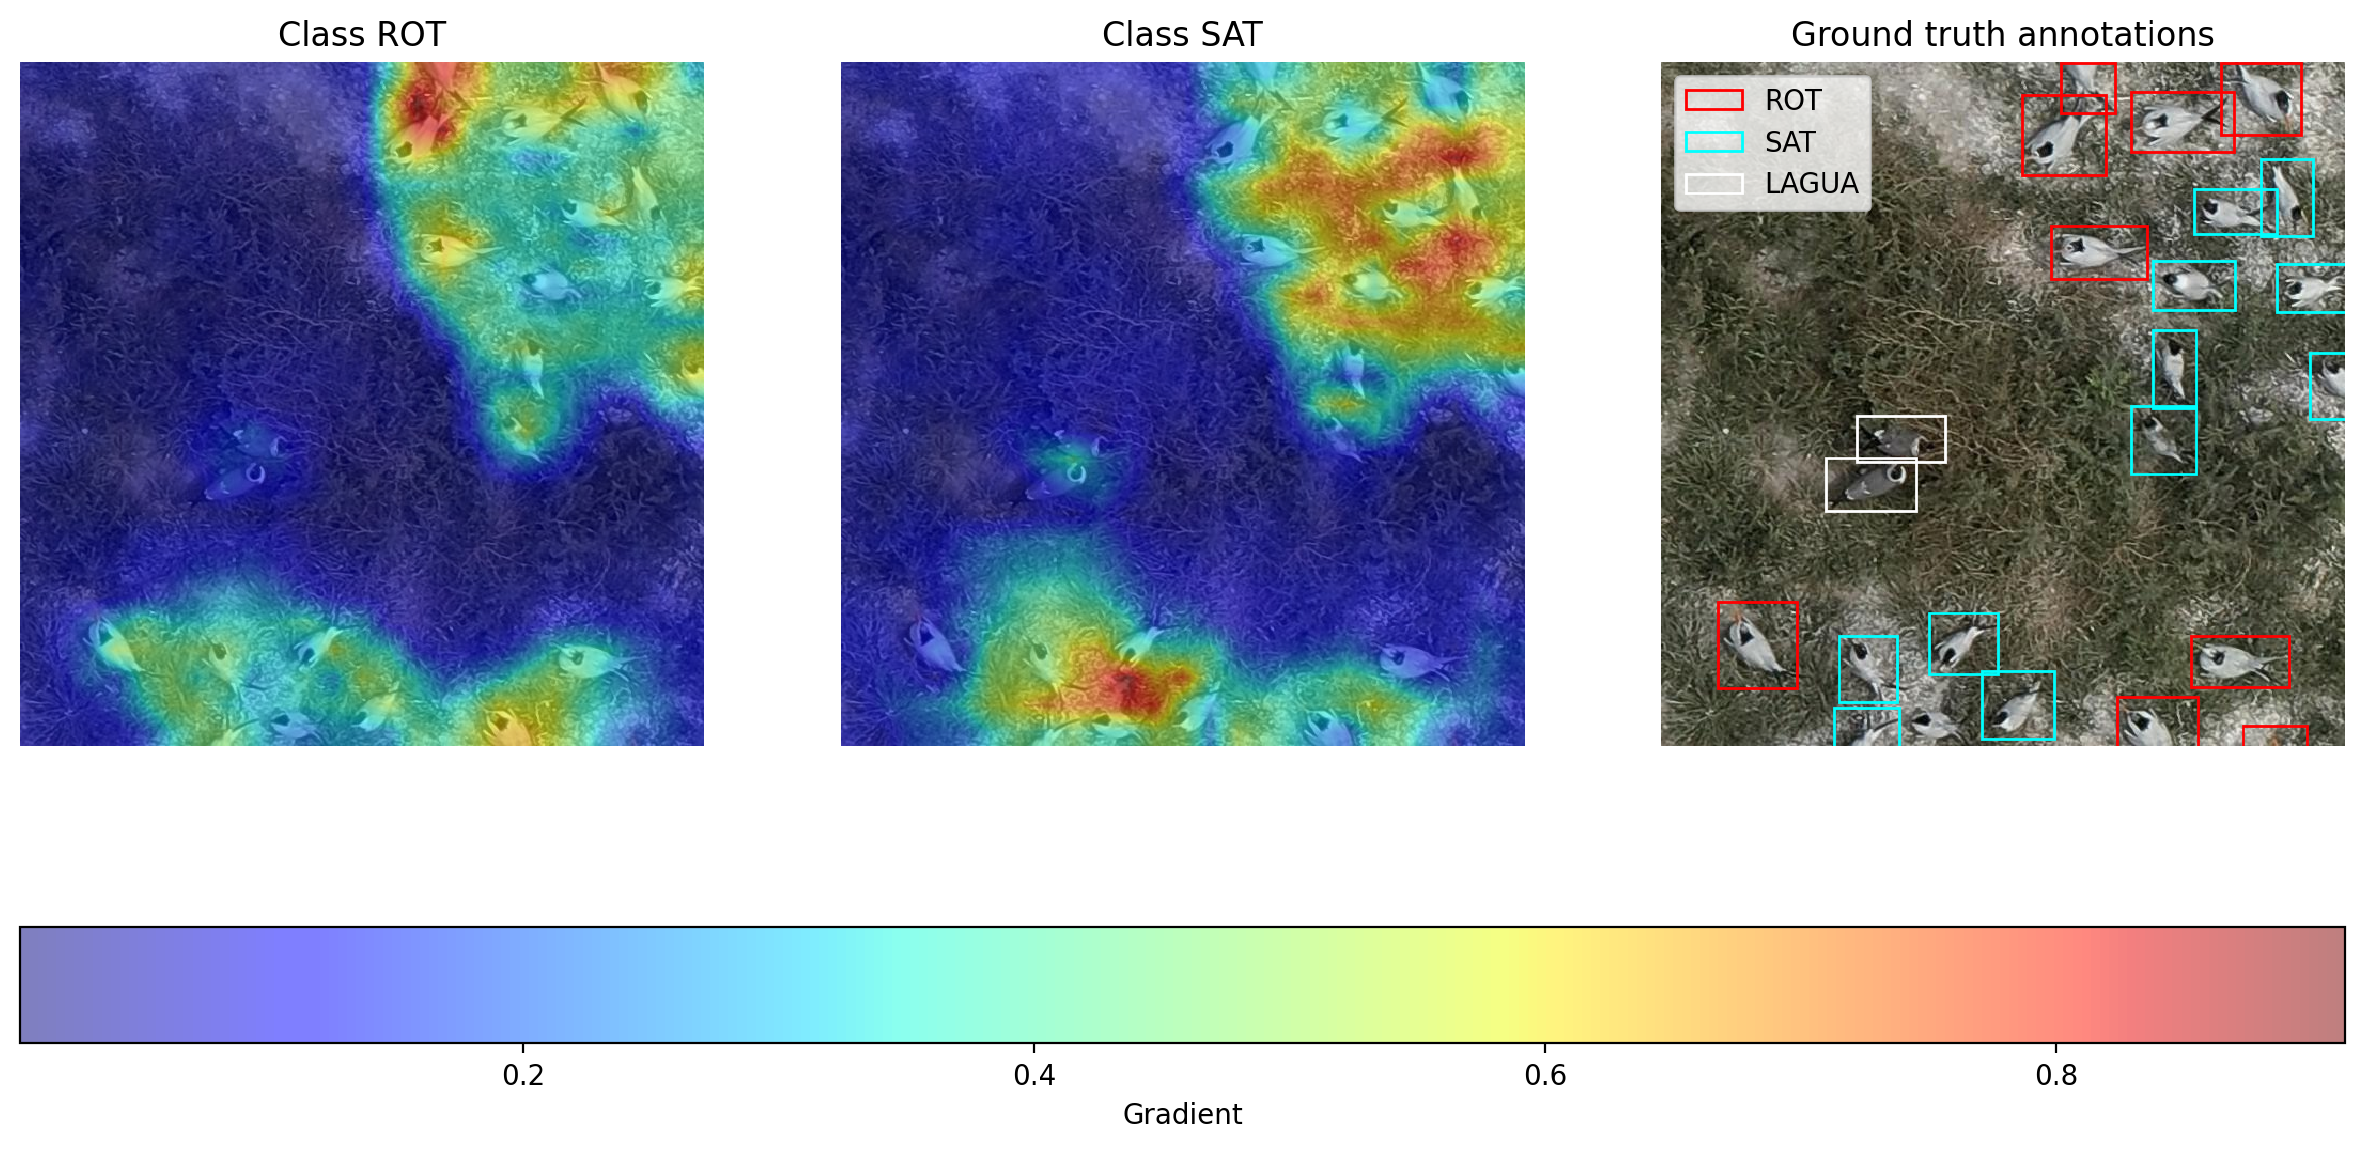

In [20]:
# visualization
fig, axes = plt.subplots(1,3, dpi=200, figsize=(15,8))
[ax.axis('off') for ax in axes]

# ground truth annotations
ax = axes[-1]
im = cv2.cvtColor(cv2.imread(img_file), cv2.COLOR_RGB2BGR) 
ax.imshow(im, interpolation='none')
ax.set_title('Ground truth annotations')

pd_csv = pd.read_csv(img_file.replace('JPEG','csv'))
for bx in pd_csv.iterrows():
    rect = patches.Rectangle((bx[1].x, bx[1].y), bx[1].width, bx[1].height, 
                             linewidth=1, edgecolor=colors[bx[1].class_id], 
                             facecolor='none', label=bx[1].class_id)
    ax.add_patch(rect)
handles, labels = ax.get_legend_handles_labels()
by_label = dict(zip(labels, handles))
ax.legend(by_label.values(), by_label.keys())

# by-class gradcam results for terns
im_cam_terns = {k:v for k,v in im_cam.items() if k in ['ROT', 'SAT']}
for i, (lab, cam) in enumerate(im_cam_terns.items()):
    ax = axes[i]
    im = cv2.cvtColor(cv2.imread(img_file), cv2.COLOR_RGB2BGR) 
    ax.imshow(im, interpolation = 'none')
    ims = ax.imshow(cam, cmap = 'jet', alpha = 0.5)
    clb = plt.colorbar(ims, ax = axes.ravel().tolist(), orientation = 'horizontal',
                       location = 'bottom', label = 'Gradient') if not i else None
    ax.set_title(f'Class {lab}')

# plt.tight_layout()
plt.show()